In [165]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout

data = pd.read_csv('../dataset/job_postings_dataset.csv')
data.head(10)

,id,time,city,job,number_employees,major,level
0,1,1695908160000,Hà Nội,ReactJs,1,Công nghệ thông tin,fresher
1,2,1685487066000,Hồ Chí Minh,Backend Developer,2,Công nghệ thông tin,fresher
2,3,1689072962000,Hồ Chí Minh,NodeJs,2,Công nghệ thông tin,senior
3,4,1714943190000,Hồ Chí Minh,DevOps Engineer,2,Công nghệ thông tin,fresher
4,5,1683174806000,Hà Nội,Frontend Developer,2,Công nghệ thông tin,senior
5,6,1677120936000,Hồ Chí Minh,Python Developer,3,Công nghệ thông tin,junior
6,7,1695921879000,Hồ Chí Minh,DevOps Engineer,2,Công nghệ thông tin,senior
7,8,1683552476000,Hà Nội,Python Developer,1,Công nghệ thông tin,intern
8,9,1676637659000,Hồ Chí Minh,Backend Developer,1,Công nghệ thông tin,senior
9,10,1683103577000,Hồ Chí Minh,DevOps Engineer,3,Công nghệ thông tin,middle


In [166]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                60000 non-null  int64 
 1   time              60000 non-null  int64 
 2   city              60000 non-null  object
 3   job               60000 non-null  object
 4   number_employees  60000 non-null  int64 
 5   major             60000 non-null  object
 6   level             60000 non-null  object
dtypes: int64(3), object(4)
memory usage: 3.2+ MB


In [167]:
# Chuyển đổi cột 'time' từ Unix timestamp sang datetime
data['time'] = pd.to_datetime(data['time'], unit='ms')

# Thêm cột 'month' để tổng hợp theo tháng
data['month'] = data['time'].dt.to_period('M')

# Tổng hợp dữ liệu theo 'job', 'city', 'month'
aggregated_data = data.groupby(['job', 'city', 'month']).size().reset_index(name='job_postings_count')

# Kiểm tra dữ liệu sau khi tổng hợp
print(aggregated_data.head())

                 job    city    month  job_postings_count
0  Backend Developer  Hà Nội  2023-01                 122
1  Backend Developer  Hà Nội  2023-02                 105
2  Backend Developer  Hà Nội  2023-03                 133
3  Backend Developer  Hà Nội  2023-04                  89
4  Backend Developer  Hà Nội  2023-05                 102


In [168]:
aggregated_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589 entries, 0 to 588
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype    
---  ------              --------------  -----    
 0   job                 589 non-null    object   
 1   city                589 non-null    object   
 2   month               589 non-null    period[M]
 3   job_postings_count  589 non-null    int64    
dtypes: int64(1), object(2), period[M](1)
memory usage: 18.5+ KB


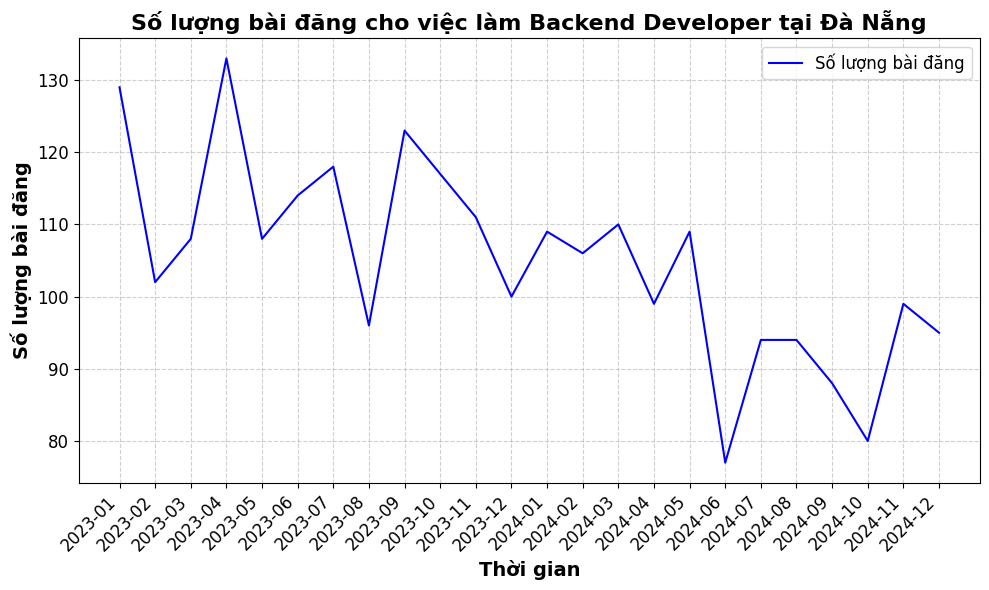

In [169]:
def plot_job_trend(job, city):
    job_data = aggregated_data[(aggregated_data['job'] == job) & (aggregated_data['city'] == city)]
    
    plt.figure(figsize=(10, 6))
    plt.plot(job_data['month'].astype(str), job_data['job_postings_count'], linestyle='-', color='b', label='Số lượng bài đăng')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xlabel('Thời gian', fontsize=14, fontweight='bold')
    plt.ylabel('Số lượng bài đăng', fontsize=14, fontweight='bold')
    plt.title(f'Số lượng bài đăng cho việc làm {job} tại {city}', fontsize=16, fontweight='bold')
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

plot_job_trend('Backend Developer', 'Đà Nẵng')

In [170]:
# Chuẩn hóa cột 'job_postings_count'
scaler = MinMaxScaler(feature_range=(0, 1))
aggregated_data['job_postings_count_scaled'] = scaler.fit_transform(aggregated_data['job_postings_count'].values.reshape(-1, 1))

# Mã hóa cột 'job' và 'city' với LabelEncoder
job_encoder = LabelEncoder()
city_encoder = LabelEncoder()
aggregated_data['job_encoded'] = job_encoder.fit_transform(aggregated_data['job'])
aggregated_data['city_encoded'] = city_encoder.fit_transform(aggregated_data['city'])

In [171]:
print(aggregated_data.head())

                 job    city    month  job_postings_count  \
0  Backend Developer  Hà Nội  2023-01                 122   
1  Backend Developer  Hà Nội  2023-02                 105   
2  Backend Developer  Hà Nội  2023-03                 133   
3  Backend Developer  Hà Nội  2023-04                  89   
4  Backend Developer  Hà Nội  2023-05                 102   

   job_postings_count_scaled  job_encoded  city_encoded  
0                   0.864286            0             0  
1                   0.742857            0             0  
2                   0.942857            0             0  
3                   0.628571            0             0  
4                   0.721429            0             0  


In [172]:
# Define a function to create the dataset
def create_time_series(df, time_step=1):
    dataX, dataY = [], []
    for i in range(len(df)-time_step-1):
        dataX.append(df[i:(i+time_step)])
        dataY.append(df[i + time_step])
    return np.array(dataX), np.array(dataY)

# Prepare the data
features = ['job_encoded', 'city_encoded', 'job_postings_count_scaled']
data_values = aggregated_data[features].values

time_step = 12
X, y = create_time_series(data_values, time_step)

In [173]:
# Chia dữ liệu thành tập train và test
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Reshape dữ liệu để phù hợp với mô hình LSTM
X_train = X_train.reshape(X_train.shape[0], time_step, len(features))
X_test = X_test.reshape(X_test.shape[0], time_step, len(features))

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(460, 12, 3) (460, 3)
(116, 12, 3) (116, 3)


In [174]:
# Create the Bi-LSTM model
model = Sequential()
model.add(LSTM(200, return_sequences=True, input_shape=(time_step, len(features))))
model.add(Dropout(0.2))
model.add(LSTM(200, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

c:\Data\VScode-Workspace\CapstoneProject\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_63 (LSTM)                  │ (None, 12, 200)        │       163,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_58 (Dropout)            │ (None, 12, 200)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_64 (LSTM)                  │ (None, 200)            │       320,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_59 (Dropout)            │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 25)             │         5,025 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 489,051 (1.87 MB)

 Trainable params: 489,051 (1.87 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.1304 - val_loss: 0.0328 - learning_rate: 0.0010
Epoch 2/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0283 - val_loss: 0.0368 - learning_rate: 0.0010
Epoch 3/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0245 - val_loss: 0.0338 - learning_rate: 0.0010
Epoch 4/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0256 - val_loss: 0.0943 - learning_rate: 0.0010
Epoch 5/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0256 - val_loss: 0.0322 - learning_rate: 0.0010
Epoch 6/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0187 - val_loss: 0.0312 - learning_rate: 0.0010
Epoch 7/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0249 - val_loss: 0.0386 - learning_rate: 0.0010
Epoch 8/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0210 - val_loss: 0.0319 - learning_rate: 0.0010
Epoch 9/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0233 - val_loss: 0.0320 - learning_rate: 0.0010
Epoch 10/2

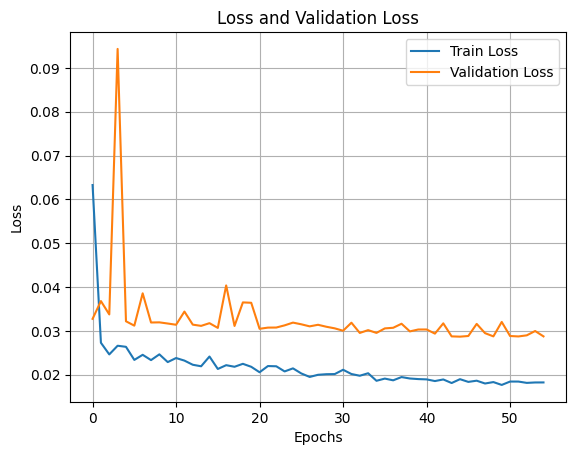

In [175]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Define callbacks
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6, verbose=1
)
early_stopping = EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train, y_train[:, 2],
    epochs=200,
    batch_size=10,
    verbose=1,
    callbacks=[early_stopping, reduce_lr],
    validation_data=(X_test, y_test[:, 2]),
)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

In [176]:
# Make predictions
# train_predict = model.predict(X_train)
# test_predict = model.predict(X_test)

# Inverse transform the predictions and actual values
train_predict = scaler.inverse_transform(model.predict(X_train))
test_predict = scaler.inverse_transform(model.predict(X_test))
y_train_inv = scaler.inverse_transform(y_train[:, 2].reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test[:, 2].reshape(-1, 1))

train_score = np.sqrt(mean_squared_error(y_train_inv, train_predict))
test_score = np.sqrt(mean_squared_error(y_test_inv, test_predict))

print(f'BiLSTM Train RMSE: {train_score}')
print(f'BiLSTM Test RMSE: {test_score}')

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
BiLSTM Train RMSE: 18.707325569355497
BiLSTM Test RMSE: 23.716458476133674


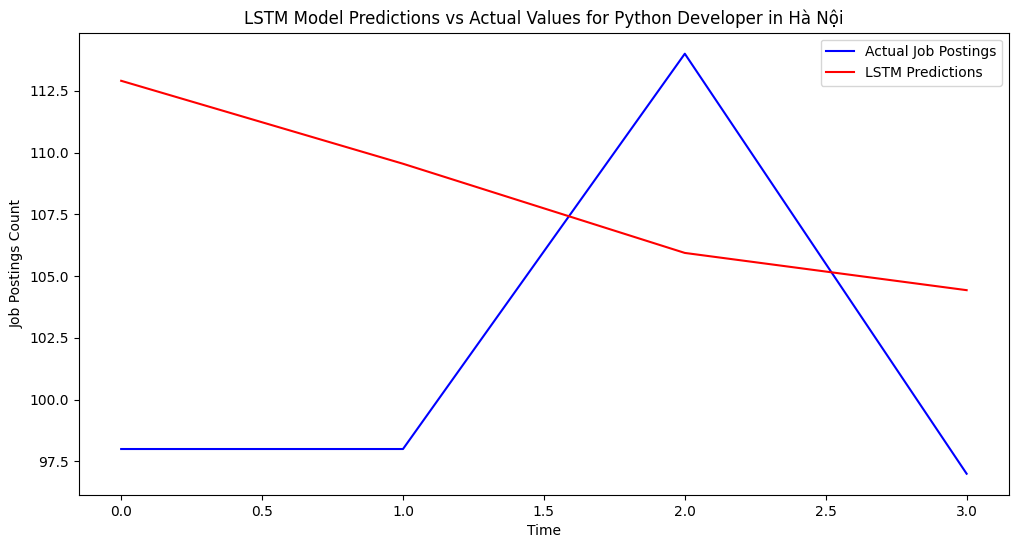

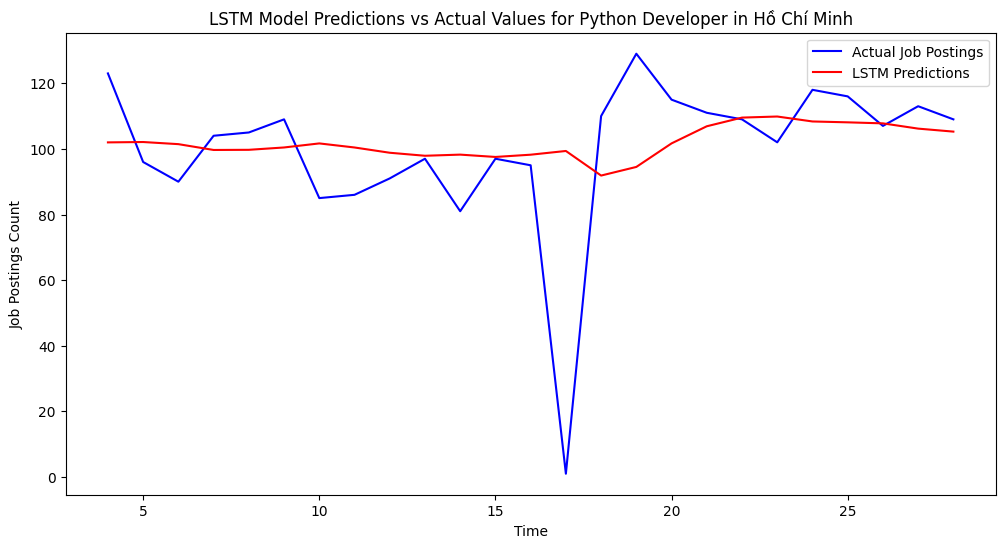

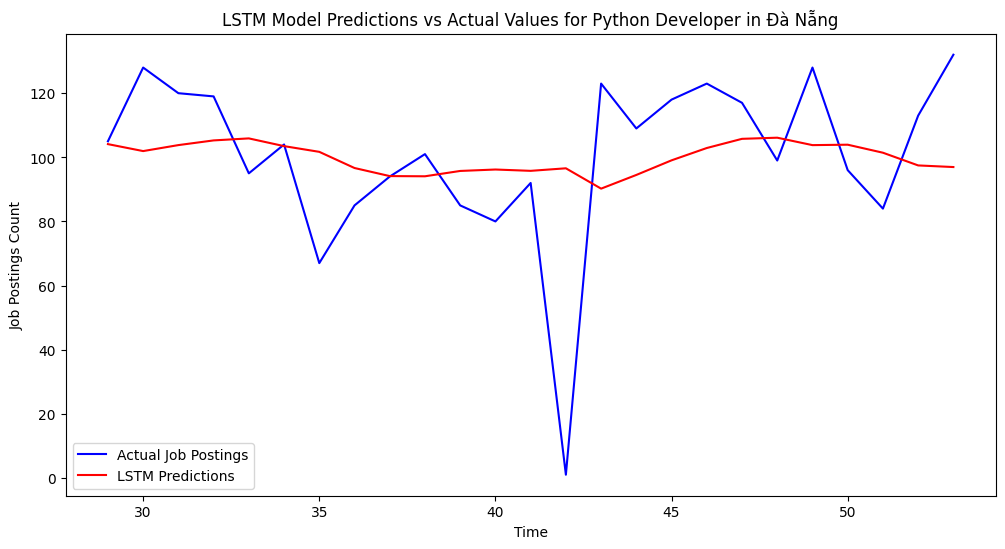

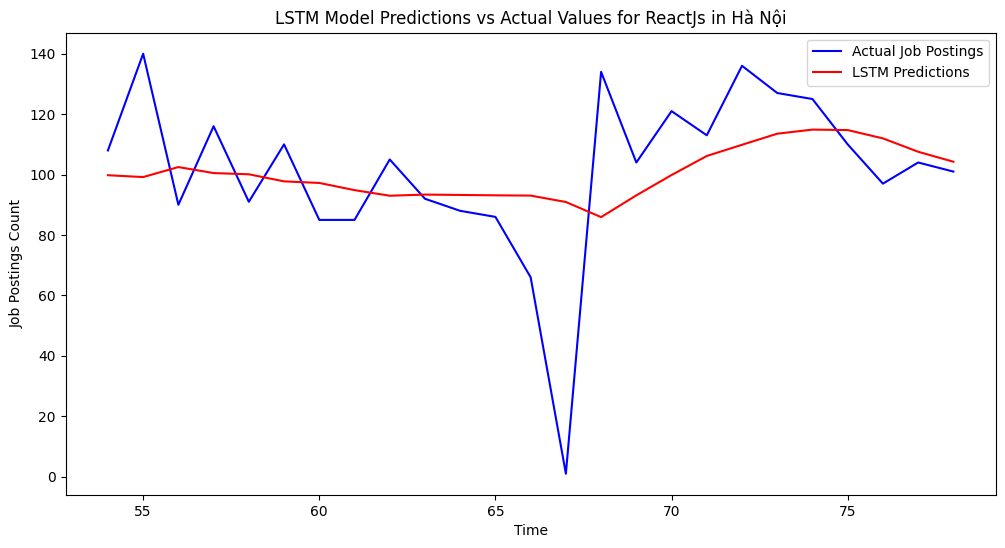

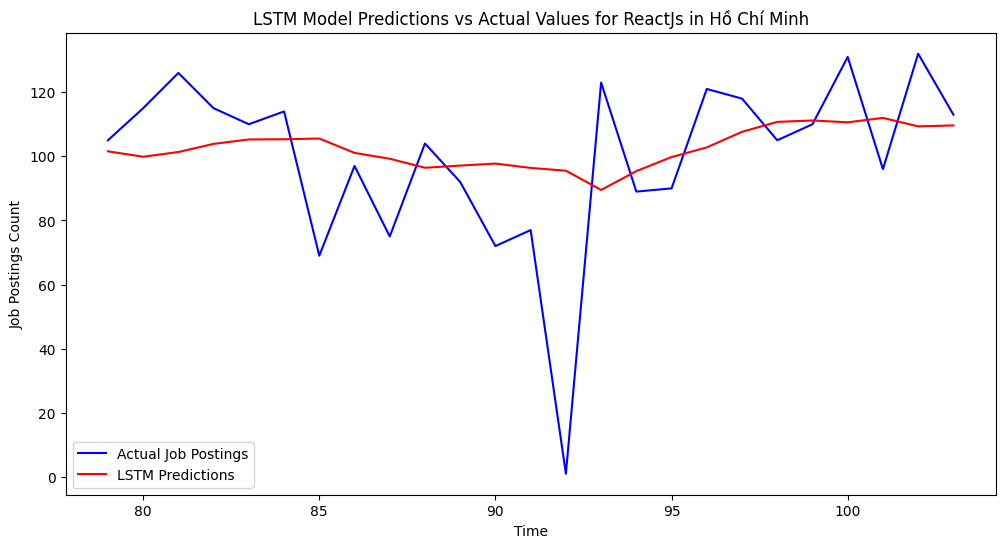

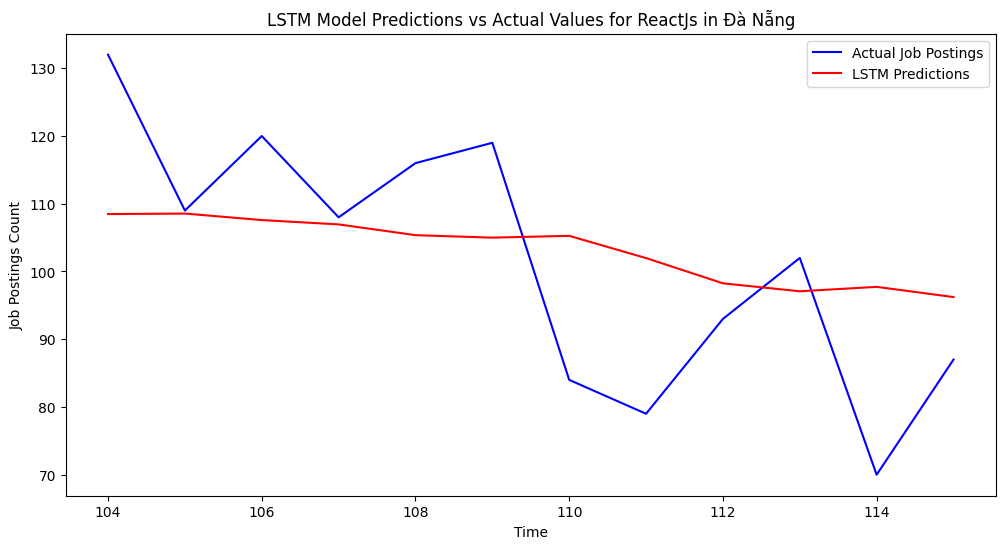

In [177]:
# Function to plot actual and predicted values for each job and city in the test set
def plot_predictions_for_jobs_and_cities(X_test, y_test_inv, test_predict, job_encoder, city_encoder):
    job_encoded = X_test[:, 0, 0]
    city_encoded = X_test[:, 0, 1]

    # Create a DataFrame for the test data with job and city information
    test_data = pd.DataFrame({
        'job_encoded': job_encoded,
        'city_encoded': city_encoded,
        'actual': y_test_inv.flatten(),
        'predicted': test_predict.flatten()
    })
    test_data['job'] = job_encoder.inverse_transform(test_data['job_encoded'].astype(int))
    test_data['city'] = city_encoder.inverse_transform(test_data['city_encoded'].astype(int))

    unique_jobs = test_data['job'].unique()
    unique_cities = test_data['city'].unique()

    for job in unique_jobs:
        for city in unique_cities:
            job_city_data = test_data[(test_data['job'] == job) & (test_data['city'] == city)]
            if len(job_city_data) > 0:
                plt.figure(figsize=(12, 6))
                plt.plot(job_city_data.index, job_city_data['actual'], label='Actual Job Postings', color='blue')
                plt.plot(job_city_data.index, job_city_data['predicted'], label='LSTM Predictions', color='red')
                plt.xlabel('Time')
                plt.ylabel('Job Postings Count')
                plt.title(f'LSTM Model Predictions vs Actual Values for {job} in {city}')
                plt.legend()
                plt.show()

# Plot predictions for each job and city in the test set
plot_predictions_for_jobs_and_cities(X_test, y_test_inv, test_predict, job_encoder, city_encoder)

In [178]:
# Predict future job postings for a specific job and city
def predict_future(job, city, time_step=12, future_periods=12):
    job_encoded = job_encoder.transform([job])[0]
    city_encoded = city_encoder.transform([city])[0]
    x_input = aggregated_data[(aggregated_data['job'] == job) & (aggregated_data['city'] == city)]['job_postings_count_scaled'].values[-time_step:]

    # Append job_encoded and city_encoded as features
    x_input = np.array([np.append([job_encoded, city_encoded], x) for x in x_input.reshape(-1, 1)])

    temp_input = x_input.tolist()
    lst_output = []

    for i in range(future_periods):
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape(1, time_step, len(features))
            yhat = model.predict(x_input, verbose=0)
            next_input = [job_encoded, city_encoded, yhat[0][0]]
            temp_input.append(next_input)
            lst_output.append(yhat[0][0])
        else:
            x_input = np.array(temp_input)
            x_input = x_input.reshape(1, len(temp_input), len(features))
            yhat = model.predict(x_input, verbose=0)
            next_input = [job_encoded, city_encoded, yhat[0][0]]
            temp_input.append(next_input)
            lst_output.append(yhat[0][0])

    # Inverse transform the predictions
    future_predict = scaler.inverse_transform(np.array(lst_output).reshape(-1, 1))
    return future_predict

# Predict future job postings for ReactJs in Hanoi
future_predictions = predict_future('ReactJs', 'Hà Nội', time_step, 6)
print(future_predictions)

[[90.92649 ]
 [91.62452 ]
 [92.59001 ]
 [94.07098 ]
 [95.198616]
 [96.330505]]
